# COMP90051 Project 2

**Copyright statement:** This notebook is copyright University of Melbourne. 
It is licensed for the sole purpose of your assessment in COMP90051. 
You are not permitted to share or publish derived versions of this notebook, other than with COMP90051 staff for assessment.

***

The code block below imports the namespaces/functions/classes you may use in the project. 
Additional imports are not permitted.

In [1]:
# Do not edit. These are the only imports permitted.
import numpy as np
from abc import ABC, abstractmethod

# Type annotations
from numpy import ndarray
from numpy.random import Generator
from typing import List, Deque, Optional, Tuple

from sklearn.cluster import KMeans                   # for Task 3
from sklearn.linear_model import LogisticRegression  # for Task 4
from collections import deque                        # for Task 5
from scipy.stats import multivariate_normal          # for Task 5
import matplotlib.pyplot as plt                      # for Task 6

The base `MAB` class below defines a common interface for a contextual multi-armed bandit. 
Your bandit implementations in Tasks 1-4 should inherit from this class.

In [2]:
class MAB(ABC):
    """Base class for a contextual multi-armed bandit (MAB)
    
    Parameters
    ----------
    n_arms : int
        Number of arms.
        
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, rng: Optional[Generator] = None) -> None:
        if not n_arms >= 0:
            raise ValueError("`n_arms` must be non-negative")
        self.n_arms = n_arms
        self.rng = np.random.default_rng(rng)
        
    @abstractmethod
    def play(self, context: ndarray) -> int:
        """Play a round
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors presented to the MAB. The 0-th 
            axis indexes the arms, and the 1-st axis indexes the features.
            Non-contextual bandits accept a context of None.
        
        Returns
        -------
        arm : int
            Integer index of the arm played this round. Should be in the set 
            {0, ..., n_arms - 1}.
        """
        
    @abstractmethod
    def update(self, arm: int, context: ndarray, 
               reward: Optional[float] = None) -> None:
        """Update the internal state of the MAB after a play
        
        Parameters
        ----------
        arm : int
            Integer index of the played arm in the set {0, ..., n_arms - 1}.
        
        context : float numpy.ndarray, shape (n_arms, n_dims), optional
            An array of context vectors that was presented to the MAB. The 
            0-th axis indexes the arms, and the 1-st axis indexes the 
            features. Non-contextual bandits accept a context of None.
            
        reward : float, optional
            Reward received from the arm. If None, the reward is missing.
        """
        if arm >= self.n_arms or arm < 0:
            raise ValueError("`arm` must be in the range "
                             "[0, {}]".format(self.n_arms - 1))

The function below implements off-policy evaluation as described in Appendix A of the project spec. 
You should use it—along with the provided dataset—to evaluate the bandits in Tasks 1-4.

In [3]:
def offline_eval(mab: MAB, arms: ndarray, rewards: ndarray, contexts: ndarray, 
                 n_rounds: Optional[int] = None) -> ndarray:
    """Offline evaluation of a multi-armed bandit
    
    Parameters
    ----------
    mab : instance of MAB
        MAB to evaluate.
    
    arms : int ndarray, shape (n_events,) 
        Array containing the history of pulled arms, represented as integer 
        indices in the set {0, ..., mab.n_arms}
    
    rewards : float ndarray, shape (n_events,)
        Array containing the history of rewards. If a reward is missing, it 
        should be represented by `np.nan`.
    
    contexts : float ndarray, shape (n_events, n_arms, n_dims)
        Array containing the history of contexts presented to the arms. 
        The 0-th axis indexes the events in the history, the 1-st axis 
        indexes the arms and the 2-nd axis indexed the features.
        
    n_rounds : int, optional
        Number of matching events to evaluate the MAB on. If None, 
        continue evaluating until the historical events are exhausted.
    
    Returns
    -------
    matching_rewards : ndarray
        Rewards of matched events.
    
    matching_ids : ndarray
        Indices of matched events.
    """
    # Check types
    if not isinstance(mab, MAB):
        raise TypeError("`mab` must be an instance of MAB")
    arms = np.asarray(arms)
    rewards = np.asarray(rewards)
    contexts = np.asarray(contexts)
    if n_rounds is not None and n_rounds < 0:
        raise ValueError("`n_rounds` must be non-negative")
    
    # Check array dimensions
    if arms.ndim != 1:
        raise ValueError("`arms` must be a 1D array")
    if rewards.ndim != 1:
        raise ValueError("`rewards` must be a 1D array")
    if contexts.ndim != 3:
        raise ValueError("`contexts` must be a 3D array")
    if not (arms.shape[0] == rewards.shape[0] == contexts.shape[0]):
        raise ValueError("first dimension of input arrays are inconsistent")
    if contexts.shape[1] != mab.n_arms:
        raise ValueError("`contexts` has inconsistent second dimension")
    if arms.max() >= mab.n_arms or arms.min() < 0:
        raise ValueError("`arms` contains ids that are out-of-range")
    
    matched_ctr = 0
    matched_ids = list()
    for i in range(arms.size):
        if matched_ctr >= n_rounds:
            break
        arm_id = mab.play(contexts[i])
        if arm_id == arms[i]:
            reward = None if np.isnan(rewards[i]) else rewards[i]
            mab.update(arm_id, contexts[i], reward)
            matched_ctr += 1
            matched_ids.append(i)
    
    matched_ids = np.array(matched_ids)
    return rewards[matched_ids], matched_ids

Please define any static functions/variables (used across multiple tasks) in the code block below.

In [4]:
rng = np.random.default_rng(90051)  # Random generator used throughout


In [5]:
# Define additional static functions/variables here, if required
def best_arm(A):
    """
    case1: just a unique maximum payoff
    case2: When there is the maximum payoff corresponding to many arms, evenly and randomly select.
    
    """   
    random_value = np.random.random(size=len(A))
    arm_star = np.argmax(random_value * (A==np.max(A)))    
    
    return arm_star
    

## Task 1: Implement LinUCB

In [6]:
class LinUCB(MAB):
    """LinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    
    def __init__(self, n_arms: int, n_dims: int, alpha: float, rng: Optional[Generator] = None) -> None:
        # implement or remove this method
        
        #Initialization of the parameters: n_arms,  n_dims, alpha, A_a, b_a
        self.n_arms = n_arms 
        self.n_dims = n_dims
        self.alpha = alpha
        self.A_a = [np.eye(self.n_dims) for a in range(0, self.n_arms)] #d-dim identity matrix
        self.b_a = [np.zeros((self.n_dims,1)) for a in range(0, self.n_arms)]  #d-dim zero vector
        
        
    def play(self, context: ndarray) -> int:
        # implement or remove this method
        
        p_ta=list()                                           #Initialization of p_ta

        for a in range(0,self.n_arms):                        #for each arm a
            A_a_inverse=np.linalg.inv(self.A_a[a])            #inverse of A_a matrix
            theta_hat_a=np.dot(A_a_inverse,self.b_a[a])       #coefficient estimate
            x_ta=context[a].reshape(self.n_dims,1)            #feature vector for arm a
            std_ta= np.sqrt(np.dot(np.dot(x_ta.T,A_a_inverse),x_ta))  #standard deviance of expected payoff
            prob_ta=np.dot(theta_hat_a.T, x_ta) + self.alpha * std_ta
            p_ta.append(np.squeeze(prob_ta))  
            arm_chose=best_arm(p_ta)                          #call the function 'best_arm' to find the best arm
            
        return arm_chose   
 
    
    def update(self, arm: int, context: ndarray, reward: Optional[float] = None) -> None:
        # implement or remove this method
         
        x_ta_star = context[arm].reshape(self.n_dims,1)       #feature vector for the best arm 
        
        if reward is not None:
            self.A_a[arm] = np.add(self.A_a[arm], np.dot(x_ta_star,x_ta_star.T))  #update A_a for the best arm
            self.b_a[arm] = np.add(self.b_a[arm], reward*x_ta_star)               #update b_a for the best arm
        

In [7]:
# Load dataset here
Data = np.loadtxt('dataset.txt',dtype=int)
arms = Data[:,0]
rewards = Data[:,1]
MA_rewards = Data[:,2]
context_all = Data[:,3:103]

#reshape the context to 3D
contexts=context_all.reshape(10000,10,10)  

In [8]:
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(LinUCB_rewards))

LinUCB average reward 0.53


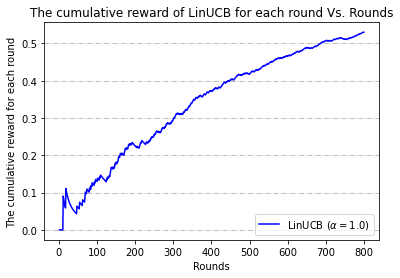

In [9]:
# Use additional cells here for experimentation
# (2) Plot the per-round cumulative reward of LinUCB

#x-axis: Rounds
rounds_num=800
x=np.linspace(1,rounds_num,num=rounds_num,dtype='int')   

#y-axis: The cumulative reward of LinUCB for each round
y=np.cumsum(LinUCB_rewards)/x

#plot
plt.plot(x, y, c="b",label=r"LinUCB $(\alpha=1.0)$")
plt.legend(loc="lower right")
plt.title("The cumulative reward of LinUCB for each round Vs. Rounds")
plt.ylabel('The cumulative reward for each round')
plt.xlabel('Rounds')
plt.grid(axis="y",linestyle='-.')
plt.show()


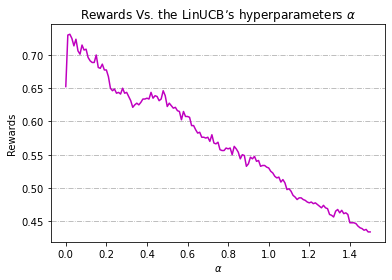

The best value of LinUCB’s hyperparameters alpha is 0.02 ,and its corresponding rewards is  0.73125


In [10]:
# (3) Grid-search for LinUCB: select alpha 
#From figure 2 in the origin paper: alpha: 0~1.5

alpha_all=np.array([i/100 for i in range(0, 151)])

alpha_opt=0
alpha_opt_reward=0
alpha_reward_list = list()
for parameter in alpha_all:
    mab = LinUCB(10, 10, parameter, rng)
    LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    alpha_reward=np.mean(LinUCB_rewards)
    alpha_reward_list.append(alpha_reward)
    if alpha_reward>alpha_opt_reward:
        alpha_opt_reward=alpha_reward
        alpha_opt=parameter

#Graph
x=alpha_all
y=np.array(alpha_reward_list)

plt.plot(x, y, c="m")
plt.title(r"Rewards Vs. the LinUCB’s hyperparameters $\alpha$ ")
plt.ylabel('Rewards')
plt.xlabel(r"$\alpha$")
plt.grid(axis="y",linestyle='-.')
plt.show()

#Number
print(r"The best value of LinUCB’s hyperparameters alpha is",alpha_opt, 
      ",and its corresponding rewards is ", alpha_opt_reward)


## Task 2: Implement MLinUCB

In [11]:
class MLinUCB(MAB):
    """MLinUCB

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.

    alpha : float
        Positive real explore-exploit parameter.
    
    N : int
        Number of clusters
        
    m : int
        Number of closest clusters to use when imputing the reward.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, alpha: float, N: int, m: int, rng: Optional[Generator] = None) -> None:
        # implement or remove this method
        
        #Initialization
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.alpha = alpha
        self.N=N
        self.m=m
        self.b_a = [np.zeros((self.n_dims,1)) for a in range(0, self.n_arms)]  #d-dim zero vector
        self.A_a = [np.eye(self.n_dims) for a in range(0, self.n_arms)]        #d-dim identity matrix
        self.oberved_imputed_context_list=list()                               #context for clustering
        self.oberved_imputed_reward_list=list()                                #reward corresponding the context for clustering
       
    
    def play(self, context: ndarray) -> int:
        # implement or remove this method
        
        p_ta=list() 
        for a in range(0,self.n_arms):                                #for each arm a
            A_a_inverse=np.linalg.inv(self.A_a[a])                    #inverse of A_a matrix
            theta_hat_a=np.dot(A_a_inverse,self.b_a[a])               #coefficient estimate
            x_ta=context[a].reshape(self.n_dims,1)                    #feature vector for arm a
            std_ta= np.sqrt(np.dot(np.dot(x_ta.T,A_a_inverse),x_ta))  #standard deviance of expected payoff
            prob_ta=np.dot(theta_hat_a.T, x_ta) + self.alpha * std_ta
            p_ta.append(np.squeeze(prob_ta)) 
            arm_chose=best_arm(p_ta)                                  #call the function 'best_arm' to find the best arm
  
        return arm_chose 


    def update(self, arm: int, context: ndarray, reward: Optional[float] = None) -> None:
        # implement or remove this method
        
        self.oberved_imputed_reward_list.append(reward)                  #reward corresponding the context for clustering
        self.oberved_imputed_context_list.append(context[arm])           #context for clustering
        oberved_imputed_context=self.oberved_imputed_context_list[:]
        
        #the number of cluster formed
        s=len(self.oberved_imputed_context_list)           #The number of instances passed to clustering
        if s<self.N:
            NN=s
        else:
            NN=self.N      
        
        #Clustering by k-means
        clf= KMeans(n_clusters=NN)
        clf.fit(oberved_imputed_context)
        data_center = clf.cluster_centers_                 #The central coordinates of each cluster    
        data_label = clf.labels_                           #The group to which each data point belongs 
        
        #Calculate the distance between the context and each cluster center
        d_j_list=list()
        for i in range(0,NN):
            d_j= np.linalg.norm(context-data_center[i])    #Euclidean distance
            d_j_list.append(d_j)
        
        #Find first m closest clusters with the smallest distances
        d_j_array=np.array(d_j_list)
        d_j_sort=np.argsort(d_j_array)                     #Ascending sort returns the index value

        #Choose m closest clusters 
        if s<self.m:
            mm=s
        else:
            mm=self.m
        
        m_d_j_ids=d_j_sort[0:mm]                           #The index of the m closest clusters
        m_d_j=d_j_array[d_j_sort[0:mm]]                    #The m smallest distance 

        #Average reward for each arm in each cluster j
        r_bar_j_list=list()
        for ids in m_d_j_ids:
            n_j=np.sum(data_label==ids)                    #sample size for each cluster 
            r_tau_sum=0                                    #total average reward for the each cluster
            for i, j in enumerate(data_label):
                if j == ids:
                    if (self.oberved_imputed_reward_list[i]==0) | (self.oberved_imputed_reward_list[i]==1):
                        r_tau_sum = r_tau_sum + self.oberved_imputed_reward_list[i]
            r_bar_j= r_tau_sum/n_j
            r_bar_j_list.append(r_bar_j)

        #Determine whether g(x) needs to be allocated to the reward    
        A=0
        B=0
        if (reward==1)|(reward==0):                        #the reward is avaliable
            self.oberved_imputed_reward_list[-1]=reward
        else:
            for j in range(0,mm):
                A=A+(r_bar_j_list[j]/(0.1+ m_d_j[j]))
                B=B+(1/(0.1+m_d_j[j]))
            g_x=A/B
            self.oberved_imputed_reward_list[-1]=g_x       #assign value to missing reward
        
        #Update the model hyperparameter if the reward is avaliable                           
        x_ta_star = context[arm].reshape(self.n_dims,1)                        #feature vector for the best arm 
        self.A_a[arm] = np.add(self.A_a[arm], np.dot(x_ta_star,x_ta_star.T))   #update A_a for the best arm
        self.b_a[arm] = np.add(self.b_a[arm], self.oberved_imputed_reward_list[-1]*x_ta_star) #update b_a for the best arm


In [12]:
# Define rewards_missing here - the rewards array from above where missing values are represented as np.nan
rewards_missing=np.zeros(Data.shape[0])
for t in range(0,Data.shape[0]):
    if MA_rewards[t]==1:                 #reward missing
        rewards_missing[t]=None
         
    else:                                #reward avaliable
        rewards_missing[t]=rewards[t]
        

In [13]:
mab = MLinUCB(10, 10, 1.0, 10, 3, rng)
MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('MLinUCB average reward', np.mean(rewards[MLinUCB_ids]))

mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, LinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
print('LinUCB average reward', np.mean(rewards[LinUCB_ids]))

MLinUCB average reward 0.3275
LinUCB average reward 0.37875


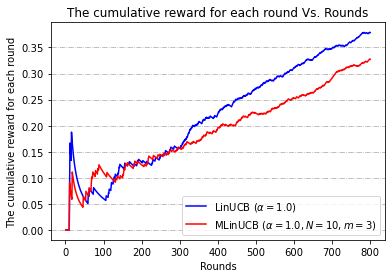

In [14]:
# Use additional cells here for experimentation
# (2) Plot the per-round cumulative reward of LinUCB & MlinUCB (with NA)

#x-axis: Rounds
rounds_num=800
x=np.linspace(1,rounds_num,num=rounds_num,dtype='int')   

#y-axis: The cumulative reward of LinUCB & MlinUCB for each round
y1=np.cumsum(rewards[LinUCB_ids])/x
y2=np.cumsum(rewards[MLinUCB_ids])/x

#plot
plt.plot(x, y1, c="b",label=r"LinUCB $(\alpha=1.0)$")
plt.plot(x, y2, c="r",label=r"MLinUCB $(\alpha=1.0, N=10, m=3)$")

plt.legend(loc="lower right")
plt.title("The cumulative reward for each round Vs. Rounds")
plt.ylabel('The cumulative reward for each round')
plt.xlabel('Rounds')
plt.grid(axis="y",linestyle='-.')
plt.show()


In [15]:
# (3) Grid-search for MLinUCB: select alpha, N, m
#The hyperparameters in the section 5 of the original paper: 
#alpha=[0,1]; N=2,5,10,15,20; m=1

alpha_all=[0.02,0.10,0.15,0.25] 
N_all=[10,15,20,25]
m_all=[1,2,4,6,8]

alpha_opt=0
N_opt=0
m_opt=0
par_opt_reward=0
reward_list = list()
for parameter1 in alpha_all:
    for parameter2 in N_all:
        for parameter3 in m_all:
            mab = MLinUCB(10, 10, parameter1, parameter2, parameter3, rng)
            MLinUCB_rewards, MLinUCB_ids = offline_eval(mab, arms, rewards_missing, contexts, 800)
            par_reward=np.mean(rewards[MLinUCB_ids])
            reward_list.append(par_reward)
            if par_reward > par_opt_reward:
                par_opt_reward=par_reward
                alpha_opt=parameter1
                N_opt=parameter2
                m_opt=parameter3
            

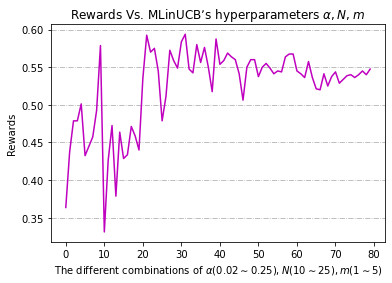

The best values of MLinUCB’s hyperparameters alpha, N, m are 0.1 , 20 , 2 ,respectively,and the corresponding rewards is 0.59375


In [16]:
#Graph
x=np.array([i for i in range(0, len(alpha_all)*len(N_all)*len(m_all))])
y=np.array(reward_list)

plt.plot(x, y, c="m")
plt.title(r"Rewards Vs. MLinUCB’s hyperparameters $\alpha, N, m$ ")
plt.ylabel('Rewards')
plt.xlabel(r"The different combinations of $\alpha(0.02\sim0.25), N(10\sim25), m(1\sim5)$")
plt.grid(axis="y",linestyle='-.')
plt.show()

#Number
print(r"The best values of MLinUCB’s hyperparameters alpha, N, m are",alpha_opt,",",N_opt,",",m_opt,",respectively,"
      "and the corresponding rewards is", par_opt_reward)
            

## Task 3: Implement SquareCB

In [17]:
class SquareCB(MAB):
    """SquareCB with a logistic regression oracle

    Parameters
    ----------
    n_arms : int
        Number of arms.

    n_dims : int
        Number of features for each arm's context.
    
    gamma : float
        Learning rate parameter.
    
    rng : Generator, optional
        A `Generator` used as an internal source of randomness. If None, a 
        default `Generator` will be constructed using `np.random.default_rng`.
    """
    def __init__(self, n_arms: int, n_dims: int, gamma: float, rng: Optional[Generator] = None) -> None:
        # implement or remove this method
        
        #Initialization
        self.n_arms = n_arms
        self.n_dims = n_dims
        self.gamma = gamma
        
        #Initialization for SqAlg (all context & loss for each arm)
        self.oberved_context_list=([[] for a in range(0, self.n_arms)])
        self.oberved_loss_list=([ [] for a in range(0, self.n_arms)])   #loss=-reward

    
    def play(self, context: ndarray) -> int:
        # implement or remove this method
        
        #Logistic Regression classifier
        clf = LogisticRegression()

        #Compute oracle’s predicted scores for each arm (loss=-reward)
        y_ta_hat=list()                                    
        for a in range(0,self.n_arms):                     
            if len(self.oberved_context_list[a])==0:              #If this arm has no historical context
                y_ta=0
            
            elif (np.array(self.oberved_loss_list[a]) == -1).all() == True:
                y_ta=-1
                
            elif (np.array(self.oberved_loss_list[a]) == 0).all() == True:
                y_ta=0
         
            else:
                x=self.oberved_context_list[a]                 
                y=self.oberved_loss_list[a]                    
                clf.fit(x, y)
                y_ta_pred=clf.predict(context[a].reshape(1, -1))  #Make prediction by Logistic Regression
                y_ta=np.squeeze(y_ta_pred)
    
            y_ta_hat.append(y_ta)
             
        #Select the arm with maximum reward(i.e. minimun loss)
        y_ta_hat_opposite=[-l for l in y_ta_hat]      #reward=-loss
        b_t=best_arm(y_ta_hat_opposite)               

        #Assign probability: p_ta to other arms
        p_ta_array=np.zeros(self.n_arms)             
        mu=self.n_arms
        
        A=0
        B=0
        for a in range(0,self.n_arms):         
            if a != b_t:                              #Probablity of the other arm (except arm b_t)
                A=mu+self.gamma * (y_ta_hat[a] - y_ta_hat[b_t])
                p_ta=1/A
                p_ta_array[a]=p_ta
                B=B+p_ta
        p_ta_array[b_t]=1-B                           #Probablity of the arm b_t
        
        #Samples algorithm's arm a_t from distribution p_ta_array
        Sample_a_t=np.array([a for a in range(0, self.n_arms)])
        arm_new_chose = np.random.choice(Sample_a_t, p=p_ta_array)
        
        return arm_new_chose
    
    
    def update(self, arm: int, context: ndarray, reward: Optional[float] = None) -> None:
        # implement or remove this method
        
        #The corresponding observed loss to the arm_new_chose
        lt_at=-reward                                 #loss=-reward
        
        #Update SqAlg
        self.oberved_context_list[arm].append(context[arm])
        self.oberved_loss_list[arm].append(lt_at)     
        

In [18]:
mab = SquareCB(10, 10, 18.0, rng)
SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
print('SquareCB average reward', np.mean(SquareCB_rewards))

SquareCB average reward 0.56


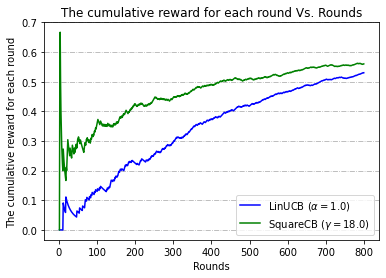

In [19]:
# Use additional cells here for experimentation
# (2) Plot the per-round cumulative reward of LinUCB & SquareCB

#x-axis: Rounds
rounds_num=800
x=np.linspace(1,rounds_num,num=rounds_num,dtype='int')   

#y-axis: The cumulative reward of LinUCB & SquareCB for each round
mab = LinUCB(10, 10, 1.0, rng)
LinUCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
y1=np.cumsum(LinUCB_rewards)/x
y3=np.cumsum(SquareCB_rewards)/x

#plot
plt.plot(x, y1, c="b",label=r"LinUCB $(\alpha=1.0)$")
plt.plot(x, y3, c="g",label=r"SquareCB $(\gamma=18.0)$")
plt.legend(loc="lower right")
plt.title("The cumulative reward for each round Vs. Rounds")
plt.ylabel('The cumulative reward for each round')
plt.xlabel('Rounds')
plt.grid(axis="y",linestyle='-.')
plt.show()



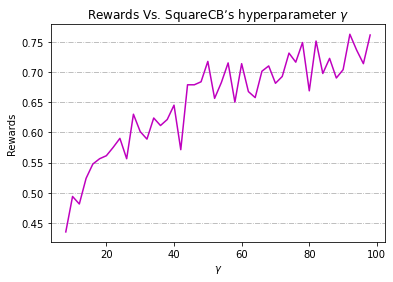

The best value of SquareCB’s hyperparameter gamma is 92 ,and its corresponding rewards is  0.7625


In [20]:
#(3) Grid-search for SquareCB: select gamma

gamma_all=np.arange(8, 100, 2)    

gamma_opt=0
gamma_opt_reward=0
gamma_reward_list = list()
for parameter in gamma_all:
    mab = SquareCB(10, 10, parameter, rng)
    SquareCB_rewards, _ = offline_eval(mab, arms, rewards, contexts, 800)
    gamma_reward=np.mean(SquareCB_rewards)
    gamma_reward_list.append(gamma_reward)
    if gamma_reward>gamma_opt_reward:
        gamma_opt_reward=gamma_reward
        gamma_opt=parameter

#Graph
x=gamma_all
y=np.array(gamma_reward_list)

plt.plot(x, y, c="m")
plt.title(r"Rewards Vs. SquareCB’s hyperparameter $\gamma$ ")
plt.ylabel('Rewards')
plt.xlabel(r"$\gamma$")
plt.grid(axis="y",linestyle='-.')
plt.show()

#Number
print(r"The best value of SquareCB’s hyperparameter gamma is",gamma_opt, 
      ",and its corresponding rewards is ", gamma_opt_reward)
